# A comparison of algorithms for solving Kakurasu puzzles

In [1]:
! pip3 install ipyfilechooser matplotlib


[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


## 1. Load a .txt file
The file must have the following format:
1. Row 1: dimension
2. Row 2: target sums for each row
3. Row 3: target sums for each column

**IMPORTANT**
**Run the next two cells in order to "Run All" notebook.**

In [2]:
from ipyfilechooser import FileChooser

# Create a file chooser starting at the current directory, filtering for .txt files
fc = FileChooser(path=".", filter_pattern="*.txt", title="Select a Kakurasu puzzle file")
display(fc)

FileChooser(path='/Users/walteramador/Documents/LU/COSC-4117EL-01-Artificial-Intelligence/Assignment_1', filen…

In [3]:
print("Selected file:", fc.selected)

def read_puzzle(file_path):
    # print the selected file content
    if file_path:
        with open(file_path, 'r') as file:
            return file.read()
    else:
        print("No file selected.")
content = read_puzzle(fc.selected)
print(content)

Selected file: /Users/walteramador/Documents/LU/COSC-4117EL-01-Artificial-Intelligence/Assignment_1/kakurasu_easy_5x5.txt
5
11,10,12,13,3
12,8,10,9,8



In [4]:
# Validate the file content format
def validate_file_format(content):
    rows = content.strip().split('\n')
    if len(rows) < 3:
        print("Invalid file format: Not enough rows.")
        return False
    dimensions = rows[0]
    if not dimensions.isdigit():
        print("Invalid file format: First line must be an integer for dimensions.")
        return False

    dimensions = int(dimensions)
    rows_target_sum = rows[1].split(',')
    cols_target_sum = rows[2].split(',')

    if len(rows_target_sum) != dimensions or len(cols_target_sum) != dimensions or len(rows_target_sum) != len(cols_target_sum):
        print("Invalid file format: Target sums do not match dimensions.")
        return False
    for sum_str in rows_target_sum:
        if not sum_str.isdigit():
            print("Invalid file format: Row target sums must be integers.")
            return False
    for sum_str in cols_target_sum:
        if not sum_str.isdigit():
            print("Invalid file format: Column target sums must be integers.")
            return False
    print("File format is valid.")
    return True

is_valid_file = validate_file_format(content)


File format is valid.


In [5]:
if not is_valid_file:
    raise ValueError("Invalid Kakurasu puzzle file format.")

# Get file values
rows = content.strip().split('\n')
rows_target_sum = rows[1].split(',')
cols_target_sum = rows[2].split(',')
for i in range(len(rows_target_sum)):
    rows_target_sum[i] = int(rows_target_sum[i])
    cols_target_sum[i] = int(cols_target_sum[i])

## 2. Display the puzzle

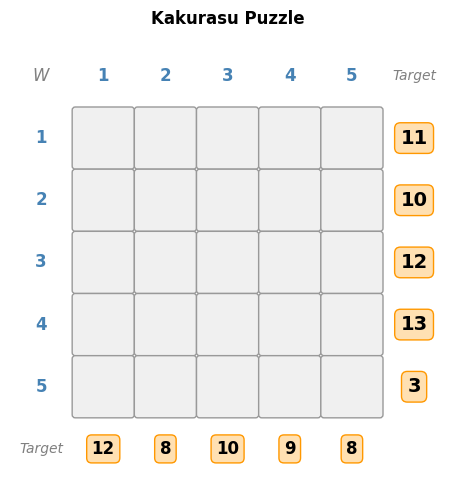

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def display_kakurasu(rows_target_sum, cols_target_sum, solution=None):
    """Display a Kakurasu puzzle grid with weights and target sums.
    If solution is None, shows the unsolved (empty) puzzle.
    solution should be a 2D list/array of 0s and 1s if provided.
    """
    n = len(rows_target_sum)
    col_weights = list(range(1, n + 1))
    row_weights = list(range(1, n + 1))

    fig, ax = plt.subplots(figsize=(n, n))

    # Draw column weights on top
    for j in range(n):
        ax.text(j + 1.5, n + 0.5, str(col_weights[j]),
                ha='center', va='center', fontsize=12, fontweight='bold', color='steelblue')

    # Draw row weights on the left
    for i in range(n):
        ax.text(0.5, n - i - 0.5, str(row_weights[i]),
                ha='center', va='center', fontsize=12, fontweight='bold', color='steelblue')

    # Draw the grid cells
    for i in range(n):
        for j in range(n):
            filled = False
            if solution is not None and solution[i][j] == 1:
                filled = True
            color = '#4CAF50' if filled else '#f0f0f0'
            textcolor = 'white' if filled else '#cccccc'
            rect = patches.FancyBboxPatch((j + 1.05, n - i - 0.95), 0.9, 0.9,
                                          boxstyle="round,pad=0.05",
                                          facecolor=color, edgecolor='#999999', linewidth=1)
            ax.add_patch(rect)
            if filled:
                ax.text(j + 1.5, n - i - 0.5, '●',
                        ha='center', va='center', fontsize=12, color=textcolor)

    # Draw row target sums on the right
    for i in range(n):
        ax.text(n + 1.5, n - i - 0.5, str(rows_target_sum[i]),
                ha='center', va='center', fontsize=14, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='#FFE0B2', edgecolor='#FF9800'))

    # Draw column target sums on the bottom
    for j in range(n):
        ax.text(j + 1.5, -0.5, str(cols_target_sum[j]),
                ha='center', va='center', fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='#FFE0B2', edgecolor='#FF9800'))

    # Labels
    ax.text(0.5, n + 0.5, 'W', ha='center', va='center', fontsize=12, fontstyle='italic', color='gray')
    ax.text(n + 1.5, n + 0.5, 'Target', ha='center', va='center', fontsize=10, fontstyle='italic', color='gray')
    ax.text(0.5, -0.5, 'Target', ha='center', va='center', fontsize=10, fontstyle='italic', color='gray')

    ax.set_xlim(0, n + 2)
    ax.set_ylim(-1, n + 1)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('Kakurasu Puzzle', fontsize=12, fontweight='bold', pad=15)
    plt.tight_layout()
    plt.show()

# Display the unsolved puzzle
display_kakurasu(rows_target_sum, cols_target_sum)

## 3. Backtracking search

In [7]:
import time

def backtracking_search(rows_target_sum, cols_target_sum, timeout=60, heuristic=None, fixed_cells=None):
    """
    Solve a Kakurasu puzzle using backtracking search.

    Parameters:
        rows_target_sum: list of target sums for each row
        cols_target_sum: list of target sums for each column
        timeout: maximum time in seconds before giving up (default 60)
        heuristic: None for pure backtracking, or "MRV", "MCV", "LCV"
            - MRV (Minimum Remaining Values): pick the cell with fewest feasible values
            - MCV (Most Constraining Variable): pick the cell with most unassigned neighbors
            - LCV (Least Constraining Value): try the value that leaves most options for neighbors
        fixed_cells: optional dict of {(i, j): value} for pre-determined cells (e.g. from AC-3)

    Returns:
        solution: nxn matrix of 0s and 1s (or None if no solution / timeout)
        elapsed_time: time taken in seconds
        nodes_visited: number of nodes explored during search
    """
    if heuristic not in (None, "MRV", "MCV", "LCV"):
        raise ValueError(f"Invalid heuristic: {heuristic}. Use None, 'MRV', 'MCV', or 'LCV'.")

    n = len(rows_target_sum)
    grid = [[-1] * n for _ in range(n)]  # -1 = unassigned
    unassigned = set((i, j) for i in range(n) for j in range(n))

    # Apply fixed cells (pre-determined by AC-3 or other preprocessing)
    if fixed_cells:
        for (i, j), val in fixed_cells.items():
            grid[i][j] = val
            unassigned.discard((i, j))

    nodes_visited = 0
    start_time = time.time()
    timed_out = False

    def is_consistent(row, col, val):
        """Check if assigning val to (row, col) is consistent with constraints."""
        old = grid[row][col]
        grid[row][col] = val

        ok = True

        # --- Row check ---
        row_sum = 0
        row_remaining = 0
        row_complete = True
        for j in range(n):
            if grid[row][j] != -1:
                row_sum += grid[row][j] * (j + 1)
            else:
                row_remaining += (j + 1)
                row_complete = False

        if row_sum > rows_target_sum[row] or row_sum + row_remaining < rows_target_sum[row]:
            ok = False
        elif row_complete and row_sum != rows_target_sum[row]:
            ok = False

        # --- Column check ---
        if ok:
            col_sum = 0
            col_remaining = 0
            col_complete = True
            for i in range(n):
                if grid[i][col] != -1:
                    col_sum += grid[i][col] * (i + 1)
                else:
                    col_remaining += (i + 1)
                    col_complete = False

            if col_sum > cols_target_sum[col] or col_sum + col_remaining < cols_target_sum[col]:
                ok = False
            elif col_complete and col_sum != cols_target_sum[col]:
                ok = False

        grid[row][col] = old
        return ok

    def get_feasible_values(row, col):
        """Return list of feasible values (0 or 1) for an unassigned cell."""
        return [v for v in [0, 1] if is_consistent(row, col, v)]

    def select_variable():
        """Select the next unassigned variable based on heuristic."""
        if heuristic == "MRV":
            # Minimum Remaining Values: pick cell with fewest legal values
            return min(unassigned, key=lambda cell: len(get_feasible_values(cell[0], cell[1])))
        elif heuristic == "MCV":
            # Most Constraining Variable (degree heuristic):
            # pick cell sharing constraints with most unassigned neighbors
            return max(unassigned, key=lambda cell: (
                sum(1 for j in range(n) if j != cell[1] and (cell[0], j) in unassigned) +
                sum(1 for i in range(n) if i != cell[0] and (i, cell[1]) in unassigned)
            ))
        else:
            # Fixed row-major order (pure backtracking or LCV)
            return min(unassigned)

    def order_values(row, col):
        """Order domain values based on heuristic."""
        if heuristic == "LCV":
            # Least Constraining Value: try value that leaves most options for neighbors
            feasible = get_feasible_values(row, col)
            if len(feasible) <= 1:
                return feasible

            def neighbor_options(val):
                grid[row][col] = val
                total = 0
                # Count feasible values for all unassigned neighbors in same row
                for j in range(n):
                    if j != col and (row, j) in unassigned:
                        total += sum(1 for v in [0, 1] if is_consistent(row, j, v))
                # Count feasible values for all unassigned neighbors in same column
                for i in range(n):
                    if i != row and (i, col) in unassigned:
                        total += sum(1 for v in [0, 1] if is_consistent(i, col, v))
                grid[row][col] = -1
                return total

            # Sort descending by neighbor options (most options first = least constraining)
            return sorted(feasible, key=lambda v: -neighbor_options(v))
        else:
            # Default order: try 0 then 1
            return [0, 1]

    def solve():
        nonlocal nodes_visited, timed_out

        if time.time() - start_time > timeout:
            timed_out = True
            return False

        if not unassigned:
            return True  # All cells assigned consistently

        row, col = select_variable()
        nodes_visited += 1

        for value in order_values(row, col):
            if is_consistent(row, col, value):
                grid[row][col] = value
                unassigned.discard((row, col))

                if solve():
                    return True

                if timed_out:
                    return False

                # Backtrack
                grid[row][col] = -1
                unassigned.add((row, col))

        return False

    found = solve()
    elapsed_time = time.time() - start_time
    label = heuristic or "pure"

    if timed_out:
        print(f"Backtracking ({label}) timed out after {timeout}s. Nodes visited: {nodes_visited}")
        return None, elapsed_time, nodes_visited
    elif not found:
        print(f"No solution found ({label}). Nodes visited: {nodes_visited}")
        return None, elapsed_time, nodes_visited
    else:
        solution = [[max(0, grid[i][j]) for j in range(n)] for i in range(n)]
        print(f"Solution found ({label}) in {elapsed_time:.8f}s. Nodes visited: {nodes_visited}")
        return solution, elapsed_time, nodes_visited


Running pure backtracking search...
Solution found (pure) in 0.00045204s. Nodes visited: 162

Time: 0.00045204s | Nodes visited: 162


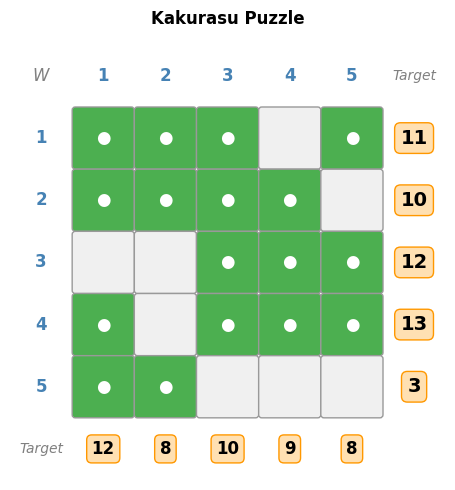


Running backtracking search with MRV heuristic...
Solution found (MRV) in 0.00063515s. Nodes visited: 25

Time: 0.00063515s | Nodes visited: 25

Running backtracking search with MCV heuristic...
Solution found (MCV) in 0.00138092s. Nodes visited: 88

Time: 0.00138092s | Nodes visited: 88

Running backtracking search with LCV heuristic...
Solution found (LCV) in 0.00038314s. Nodes visited: 40

Time: 0.00038314s | Nodes visited: 40


In [8]:
# Run pure backtracking (no heuristic)
print("\nRunning pure backtracking search...")
bt_solution, bt_time, bt_nodes = backtracking_search(rows_target_sum, cols_target_sum, timeout=60)

if bt_solution is not None:
    print(f"\nTime: {bt_time:.8f}s | Nodes visited: {bt_nodes}")
    display_kakurasu(rows_target_sum, cols_target_sum, solution=bt_solution)

# Run with MRV heuristic
print("\nRunning backtracking search with MRV heuristic...")
mrv_solution, mrv_time, mrv_nodes = backtracking_search(rows_target_sum, cols_target_sum, timeout=60, heuristic="MRV")

if mrv_solution is not None:
    print(f"\nTime: {mrv_time:.8f}s | Nodes visited: {mrv_nodes}")
    # display_kakurasu(rows_target_sum, cols_target_sum, solution=mrv_solution)

# Run with MCV heuristic
print("\nRunning backtracking search with MCV heuristic...")
mcv_solution, mcv_time, mcv_nodes = backtracking_search(rows_target_sum, cols_target_sum, timeout=60, heuristic="MCV")

if mcv_solution is not None:
    print(f"\nTime: {mcv_time:.8f}s | Nodes visited: {mcv_nodes}")
    # display_kakurasu(rows_target_sum, cols_target_sum, solution=mcv_solution)

# Run with LCV heuristic
print("\nRunning backtracking search with LCV heuristic...")
lcv_solution, lcv_time, lcv_nodes = backtracking_search(rows_target_sum, cols_target_sum, timeout=60, heuristic="LCV")

if lcv_solution is not None:
    print(f"\nTime: {lcv_time:.8f}s | Nodes visited: {lcv_nodes}")
    # display_kakurasu(rows_target_sum, cols_target_sum, solution=lcv_solution)

## 4. AC-3 Algorithm

In [9]:
import time
from collections import deque

def ac3_search(rows_target_sum, cols_target_sum, timeout=60, heuristic=None):
    """
    Solve a Kakurasu puzzle using AC-3 (Arc Consistency 3) for domain pruning,
    then falling back to backtracking_search for any remaining unresolved cells.

    Parameters:
        rows_target_sum: list of target sums for each row
        cols_target_sum: list of target sums for each column
        timeout: maximum time in seconds before giving up (default 60)
        heuristic: heuristic to pass to backtracking_search fallback
                   (None, "MRV", "MCV", or "LCV")

    Returns:
        solution: nxn matrix of 0s and 1s (or None if no solution / timeout)
        elapsed_time: time taken in seconds
        nodes_visited: number of nodes explored during search
    """
    n = len(rows_target_sum)
    start_time = time.time()

    # --- Build CSP domains ---
    domains = {(i, j): {0, 1} for i in range(n) for j in range(n)}

    def get_row_peers(i):
        return [(i, j) for j in range(n)]

    def get_col_peers(j):
        return [(i, j) for i in range(n)]

    def get_arcs():
        arcs = deque()
        for i in range(n):
            for j in range(n):
                if len(domains[(i, j)]) > 0:
                    arcs.append(((i, j), ('row', i)))
                    arcs.append(((i, j), ('col', j)))
        return arcs

    def revise(var, constraint_id):
        """Remove values from var's domain that can't satisfy the constraint."""
        revised = False
        ctype, idx = constraint_id

        if ctype == 'row':
            cells = get_row_peers(idx)
            target = rows_target_sum[idx]
            weight_fn = lambda cell: cell[1] + 1
        else:
            cells = get_col_peers(idx)
            target = cols_target_sum[idx]
            weight_fn = lambda cell: cell[0] + 1

        other_cells = [c for c in cells if c != var]

        to_remove = set()
        for val in domains[var]:
            my_contribution = val * weight_fn(var)

            other_min = 0
            other_max = 0
            for c in other_cells:
                contributions = [v * weight_fn(c) for v in domains[c]]
                if not contributions:
                    to_remove.add(val)
                    break
                other_min += min(contributions)
                other_max += max(contributions)
            else:
                if target < my_contribution + other_min or target > my_contribution + other_max:
                    to_remove.add(val)

        for val in to_remove:
            domains[var].discard(val)
            revised = True

        return revised

    def ac3():
        """Run AC-3. Returns True if consistent, False if a domain is emptied."""
        queue = get_arcs()

        while queue:
            if time.time() - start_time > timeout:
                return False

            var, constraint_id = queue.popleft()

            if revise(var, constraint_id):
                if len(domains[var]) == 0:
                    return False

                row_i, col_j = var
                if constraint_id != ('row', row_i):
                    for c in get_row_peers(row_i):
                        if c != var:
                            queue.append((c, ('row', row_i)))
                if constraint_id != ('col', col_j):
                    for c in get_col_peers(col_j):
                        if c != var:
                            queue.append((c, ('col', col_j)))

        return True

    # --- Run AC-3 ---
    consistent = ac3()
    ac3_elapsed = time.time() - start_time

    if not consistent:
        print(f"AC-3 found inconsistency in {ac3_elapsed:.8f}s.")
        return None, ac3_elapsed, 0

    # Extract fixed cells (domains reduced to a single value)
    fixed_cells = {}
    all_solved = True
    for (i, j), vals in domains.items():
        if len(vals) == 1:
            fixed_cells[(i, j)] = next(iter(vals))
        else:
            all_solved = False

    # If AC-3 solved everything, verify and return
    if all_solved:
        solution = [[fixed_cells[(i, j)] for j in range(n)] for i in range(n)]
        # Verify sums
        valid = True
        for i in range(n):
            if sum(solution[i][j] * (j + 1) for j in range(n)) != rows_target_sum[i]:
                valid = False
                break
        if valid:
            for j in range(n):
                if sum(solution[i][j] * (i + 1) for i in range(n)) != cols_target_sum[j]:
                    valid = False
                    break
        if valid:
            print(f"AC-3 solved the puzzle in {ac3_elapsed:.8f}s (no backtracking needed). "
                  f"Fixed {len(fixed_cells)}/{n*n} cells.")
            return solution, ac3_elapsed, 0

    # Fall back to backtracking_search with AC-3 pruned cells and chosen heuristic
    remaining_timeout = max(0, timeout - ac3_elapsed)
    fixed_count = len(fixed_cells)
    label = heuristic or "pure"
    print(f"AC-3 fixed {fixed_count}/{n*n} cells in {ac3_elapsed:.8f}s. "
          f"Falling back to backtracking ({label}) for remaining cells...")

    solution, bt_time, bt_nodes = backtracking_search(
        rows_target_sum, cols_target_sum,
        timeout=remaining_timeout,
        heuristic=heuristic,
        fixed_cells=fixed_cells
    )

    total_time = time.time() - start_time
    return solution, total_time, bt_nodes


Running AC-3 with pure backtracking fallback...
AC-3 solved the puzzle in 0.00061917s (no backtracking needed). Fixed 25/25 cells.

Total time: 0.00061917s | Backtracking nodes: 0


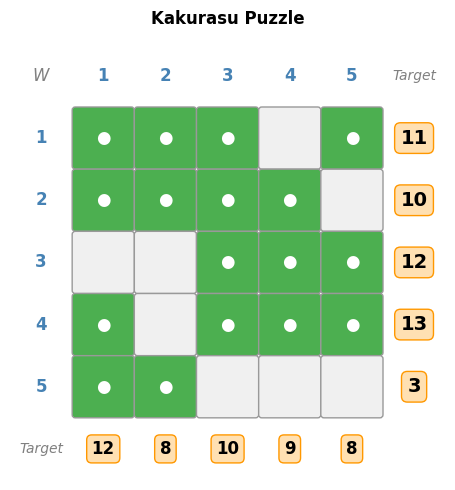


Running AC-3 with MRV backtracking fallback...
AC-3 solved the puzzle in 0.00061393s (no backtracking needed). Fixed 25/25 cells.

Total time: 0.00061393s | Backtracking nodes: 0

Running AC-3 with MCV backtracking fallback...
AC-3 solved the puzzle in 0.00048018s (no backtracking needed). Fixed 25/25 cells.

Total time: 0.00048018s | Backtracking nodes: 0

Running AC-3 with LCV backtracking fallback...
AC-3 solved the puzzle in 0.00046706s (no backtracking needed). Fixed 25/25 cells.

Total time: 0.00046706s | Backtracking nodes: 0


In [10]:
# Run AC-3 (with pure backtracking fallback)
print("\nRunning AC-3 with pure backtracking fallback...")
ac3_solution, ac3_time, ac3_nodes = ac3_search(rows_target_sum, cols_target_sum, timeout=60)

if ac3_solution is not None:
    print(f"\nTotal time: {ac3_time:.8f}s | Backtracking nodes: {ac3_nodes}")
    display_kakurasu(rows_target_sum, cols_target_sum, solution=ac3_solution)

# Run AC-3 with MRV backtracking fallback
print("\nRunning AC-3 with MRV backtracking fallback...")
ac3_mrv_solution, ac3_mrv_time, ac3_mrv_nodes = ac3_search(rows_target_sum, cols_target_sum, timeout=60, heuristic="MRV")

if ac3_mrv_solution is not None:
    print(f"\nTotal time: {ac3_mrv_time:.8f}s | Backtracking nodes: {ac3_mrv_nodes}")

# Run AC-3 with MCV backtracking fallback
print("\nRunning AC-3 with MCV backtracking fallback...")
ac3_mcv_solution, ac3_mcv_time, ac3_mcv_nodes = ac3_search(rows_target_sum, cols_target_sum, timeout=60, heuristic="MCV")
if ac3_mcv_solution is not None:
    print(f"\nTotal time: {ac3_mcv_time:.8f}s | Backtracking nodes: {ac3_mcv_nodes}")

# Run AC-3 with LCV backtracking fallback
print("\nRunning AC-3 with LCV backtracking fallback...")
ac3_lcv_solution, ac3_lcv_time, ac3_lcv_nodes = ac3_search(rows_target_sum, cols_target_sum, timeout=60, heuristic="LCV")
if ac3_lcv_solution is not None:
    print(f"\nTotal time: {ac3_lcv_time:.8f}s | Backtracking nodes: {ac3_lcv_nodes}")


## Performance comparison
We have created a batch puzzle generator. With these puzzles we are going to be running all the algorithms and heuristics to compare their performance. The generator creates puzzles of sizes 5x5, 7x7, and 9x9, with an even distribution of sizes. Each puzzle is guaranteed to have a unique solution.

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def graph_metrics(metrics):
    algorithms = sorted(set(m['algorithm'] for m in metrics))
    avg_time = {alg: np.mean([m['time'] for m in metrics if m['algorithm'] == alg]) for alg in algorithms}
    avg_nodes = {alg: np.mean([m['nodes'] for m in metrics if m['algorithm'] == alg]) for alg in algorithms}

    plt.figure(figsize=(12, 12))
    # Bar chart for average time
    plt.subplot(2, 2, 1)
    bars = plt.bar(avg_time.keys(), avg_time.values(), color='skyblue')
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 f'{bar.get_height():.4f}', ha='center', va='bottom', fontsize=8)
    plt.title('Average Time Taken by Each Algorithm (5x5 Puzzles)')
    plt.xlabel('Algorithm')
    plt.ylabel('Average Time (seconds)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Bar chart for average nodes visited
    plt.subplot(2, 2, 2)
    bars = plt.bar(avg_nodes.keys(), avg_nodes.values(), color='salmon')
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 f'{bar.get_height():.1f}', ha='center', va='bottom', fontsize=8)
    plt.title('Average Nodes Visited by Each Algorithm (5x5 Puzzles)')
    plt.xlabel('Algorithm')
    plt.ylabel('Average Nodes Visited')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Line plot x-axis each puzzle, y-axis time. One line per algorithm
    plt.subplot(2, 2, 3)
    for alg in algorithms:
        alg_times = [m['time'] for m in metrics if m['algorithm'] == alg]
        plt.plot(range(1, len(alg_times) + 1), alg_times, marker='o', label=alg)
    plt.title('Time Taken for Each Puzzle by Algorithm (5x5 Puzzles)')
    plt.xlabel('Puzzle Index')
    plt.ylabel('Time (seconds)')
    plt.xticks(range(1, len(alg_times) + 1))
    plt.grid(linestyle='--', alpha=0.7)
    plt.legend()

    # Line plot x-axis each puzzle, y-axis nodes visited. One line per algorithm
    plt.subplot(2, 2, 4)
    for alg in algorithms:
        alg_nodes = [m['nodes'] for m in metrics if m['algorithm'] == alg]
        plt.plot(range(1, len(alg_nodes) + 1), alg_nodes, marker='o', label=alg)
    plt.title('Nodes Visited for Each Puzzle by Algorithm (5x5 Puzzles)')
    plt.xlabel('Puzzle Index')
    plt.ylabel('Nodes Visited')
    plt.xticks(range(1, len(alg_nodes) + 1))
    plt.grid(linestyle='--', alpha=0.7)
    plt.legend()

    plt.tight_layout()
    plt.show()




In [12]:
def run_all_algorithms(puzzles):
    metrics = []
    for idx, puzzle in enumerate(puzzles):
        print(f"\n--- Solving Puzzle {idx + 1} ---")
        rows_target_sum = puzzle['rows_target_sum']
        cols_target_sum = puzzle['cols_target_sum']

        # Run pure backtracking (no heuristic)
        bt_solution, bt_time, bt_nodes = backtracking_search(rows_target_sum, cols_target_sum, timeout=60)
        if bt_solution is not None:
            metrics.append({
                'algorithm': 'Backtracking (pure)',
                'puzzle': idx + 1,
                'time': bt_time,
                'nodes': bt_nodes
            })
        # Run with MRV heuristic
        mrv_solution, mrv_time, mrv_nodes = backtracking_search(rows_target_sum, cols_target_sum, timeout=60, heuristic="MRV")
        if mrv_solution is not None:
            metrics.append({
                'algorithm': 'Backtracking (MRV)',
                'puzzle': idx + 1,
                'time': mrv_time,
                'nodes': mrv_nodes
            })
        # Run with MCV heuristic
        mcv_solution, mcv_time, mcv_nodes = backtracking_search(rows_target_sum, cols_target_sum, timeout=60, heuristic="MCV")
        if mcv_solution is not None:
            metrics.append({
                'algorithm': 'Backtracking (MCV)',
                'puzzle': idx + 1,
                'time': mcv_time,
                'nodes': mcv_nodes
            })
        # Run with LCV heuristic
        lcv_solution, lcv_time, lcv_nodes = backtracking_search(rows_target_sum, cols_target_sum, timeout=60, heuristic="LCV")
        if lcv_solution is not None:
            metrics.append({
                'algorithm': 'Backtracking (LCV)',
                'puzzle': idx + 1,
                'time': lcv_time,
                'nodes': lcv_nodes
            })
        # Run AC-3 (with pure backtracking fallback)
        ac3_solution, ac3_time, ac3_nodes = ac3_search(rows_target_sum, cols_target_sum, timeout=60)
        if ac3_solution is not None:
            metrics.append({
                'algorithm': 'AC-3 + Backtracking (pure)',
                'puzzle': idx + 1,
                'time': ac3_time,
                'nodes': ac3_nodes
            })
        # Run AC-3 with MRV backtracking fallback
        ac3_mrv_solution, ac3_mrv_time, ac3_mrv_nodes = ac3_search(rows_target_sum, cols_target_sum, timeout=60, heuristic="MRV")
        if ac3_mrv_solution is not None:
            metrics.append({
                'algorithm': 'AC-3 + Backtracking (MRV)',
                'puzzle': idx + 1,
                'time': ac3_mrv_time,
                'nodes': ac3_mrv_nodes
            })
        # Run AC-3 with MCV backtracking fallback
        ac3_mcv_solution, ac3_mcv_time, ac3_mcv_nodes = ac3_search(rows_target_sum, cols_target_sum, timeout=60, heuristic="MCV")
        if ac3_mcv_solution is not None:
            metrics.append({
                'algorithm': 'AC-3 + Backtracking (MCV)',
                'puzzle': idx + 1,
                'time': ac3_mcv_time,
                'nodes': ac3_mcv_nodes
            })
        # Run AC-3 with LCV backtracking fallback
        ac3_lcv_solution, ac3_lcv_time, ac3_lcv_nodes = ac3_search(rows_target_sum, cols_target_sum, timeout=60, heuristic="LCV")
        if ac3_lcv_solution is not None:
            metrics.append({
                'algorithm': 'AC-3 + Backtracking (LCV)',
                'puzzle': idx + 1,
                'time': ac3_lcv_time,
                'nodes': ac3_lcv_nodes
            })

    return metrics

In [31]:
import os
import csv

def read_batch_puzzles(file_path):
    complete_path = os.path.join(os.getcwd(), file_path)
    content_batch = read_puzzle(complete_path)
    rows = content_batch.strip().split('\n')

    puzzles_batch = []

    for row_idx in range(len(rows)):
        if row_idx % 2 == 0:  # Even lines are row target sums
            puzzles_batch.append({
                'rows_target_sum': list(map(int, rows[row_idx].split(','))),
                'cols_target_sum': list(map(int, rows[row_idx + 1].split(',')))
            })
    return puzzles_batch

def read_metrics_csv(file_path):
    try:
        complete_path = os.path.join(os.getcwd(), file_path)
        with open(complete_path, mode='r') as csvfile:
            reader = csv.DictReader(csvfile)
            metrics = []
            for row in reader:
                metrics.append({
                    'algorithm': row['algorithm'],
                    'puzzle': int(row['puzzle']),
                    'time': float(row['time']),
                    'nodes': int(row['nodes'])
                })
            return metrics
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return []

In [14]:
import csv

def save_metrics_to_csv(metrics, filename):
    keys = metrics[0].keys()
    with open(filename, 'w', newline='') as output_file:
        dict_writer = csv.DictWriter(output_file, fieldnames=keys)
        dict_writer.writeheader()
        dict_writer.writerows(metrics)

### 1. Algorithms performance comparison for 5x5 puzzles

In [34]:
metrics_5x5 = read_metrics_csv('./puzzles_metrics/kakurasu_5x5_metrics.csv')
if not metrics_5x5:
    file_5x5 = 'batch_puzzles/kakurasu_5x5_puzzles.txt'
    puzzles_5x5 = read_batch_puzzles(file_5x5)
    metrics_5x5 = run_all_algorithms(puzzles_5x5)
    save_metrics_to_csv(metrics_5x5, './puzzles_metrics/kakurasu_5x5_metrics.csv')

File not found: ./puzzles_metrics/kakurasu_5x5_metrics.csv

--- Solving Puzzle 1 ---
Solution found (pure) in 0.00033617s. Nodes visited: 104
Solution found (MRV) in 0.00088382s. Nodes visited: 25
Solution found (MCV) in 0.00547004s. Nodes visited: 298
Solution found (LCV) in 0.00182700s. Nodes visited: 185
AC-3 solved the puzzle in 0.00066829s (no backtracking needed). Fixed 25/25 cells.
AC-3 solved the puzzle in 0.00063086s (no backtracking needed). Fixed 25/25 cells.
AC-3 solved the puzzle in 0.00062704s (no backtracking needed). Fixed 25/25 cells.
AC-3 solved the puzzle in 0.00062394s (no backtracking needed). Fixed 25/25 cells.

--- Solving Puzzle 2 ---
Solution found (pure) in 0.00015712s. Nodes visited: 59
Solution found (MRV) in 0.00076318s. Nodes visited: 25
Solution found (MCV) in 0.00079298s. Nodes visited: 52
Solution found (LCV) in 0.00091696s. Nodes visited: 94
AC-3 solved the puzzle in 0.00060797s (no backtracking needed). Fixed 25/25 cells.
AC-3 solved the puzzle in 0.0

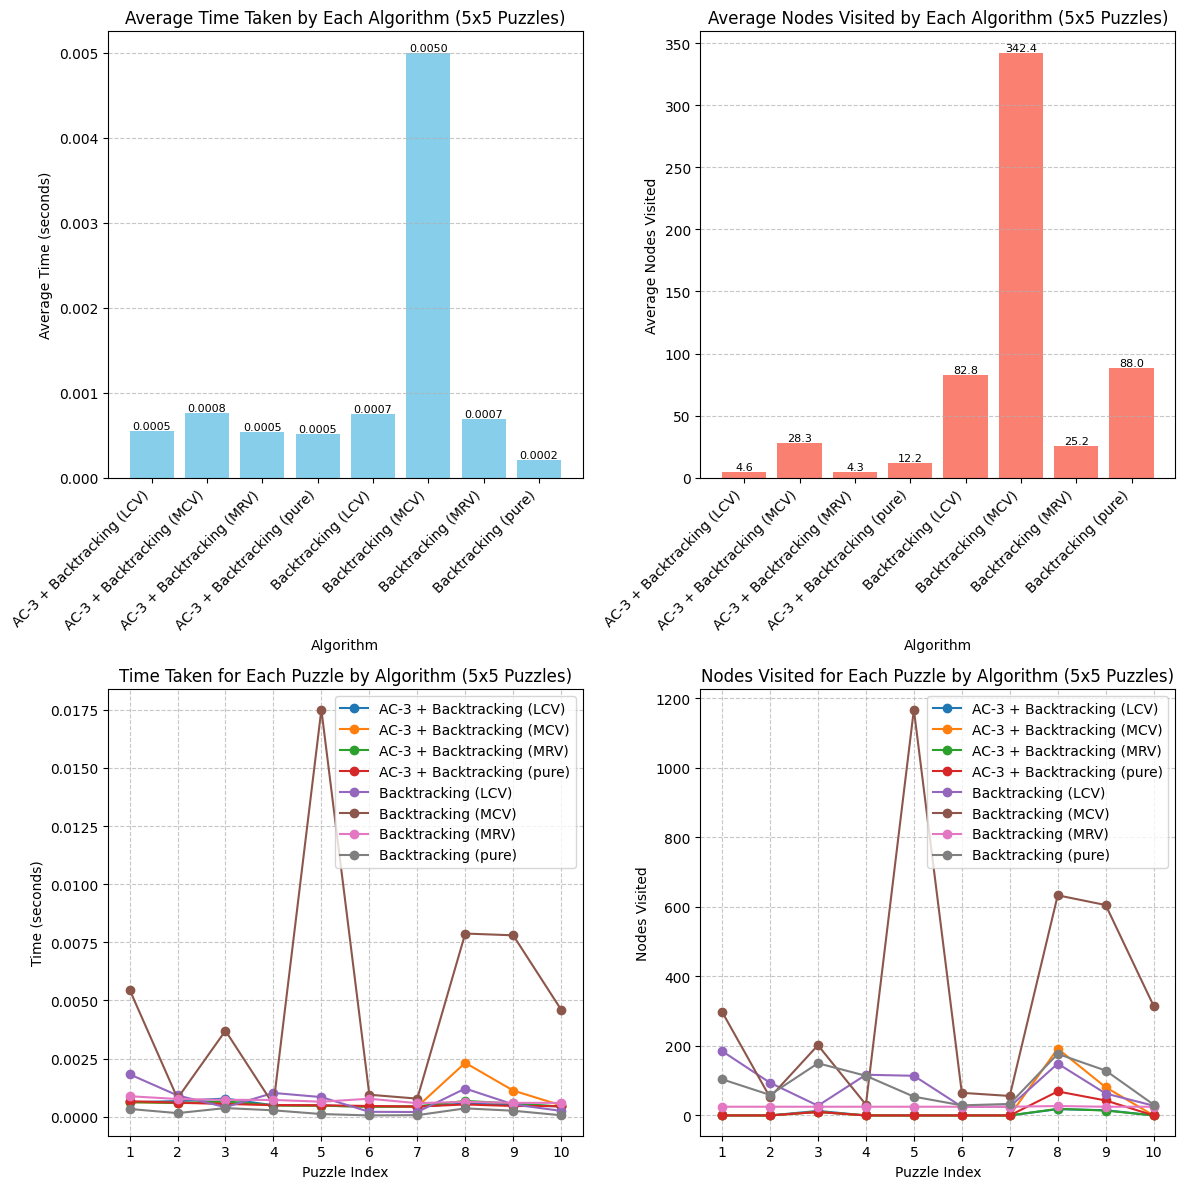

In [35]:

graph_metrics(metrics_5x5)

### 2. Algorithms performance comparison for 7x7 puzzles

In [ ]:
metrics_7x7 = read_metrics_csv('./puzzles_metrics/kakurasu_7x7_metrics.csv')
if not metrics_7x7:
    file_7x7 = 'batch_puzzles/kakurasu_7x7_puzzles.txt'
    puzzles_7x7 = read_batch_puzzles(file_7x7)
    metrics_7x7 = run_all_algorithms(puzzles_7x7)
    save_metrics_to_csv(metrics_7x7, './puzzles_metrics/kakurasu_7x7_metrics.csv')

File not found: ./puzzles_metrics/kakurasu_7x7_metrics.csv

--- Solving Puzzle 1 ---
Solution found (pure) in 0.00407314s. Nodes visited: 1387
Solution found (MRV) in 0.00825691s. Nodes visited: 100
Solution found (MCV) in 5.42559099s. Nodes visited: 225329
Solution found (LCV) in 0.01621771s. Nodes visited: 1445
AC-3 fixed 14/49 cells in 0.00116682s. Falling back to backtracking (pure) for remaining cells...
Solution found (pure) in 0.00075388s. Nodes visited: 317
AC-3 fixed 14/49 cells in 0.00099707s. Falling back to backtracking (MRV) for remaining cells...
Solution found (MRV) in 0.00416112s. Nodes visited: 86
AC-3 fixed 14/49 cells in 0.00094390s. Falling back to backtracking (MCV) for remaining cells...
Solution found (MCV) in 3.62378430s. Nodes visited: 195092
AC-3 fixed 14/49 cells in 0.00096822s. Falling back to backtracking (LCV) for remaining cells...
Solution found (LCV) in 0.00406194s. Nodes visited: 309

--- Solving Puzzle 2 ---
Solution found (pure) in 0.00082374s. Nodes

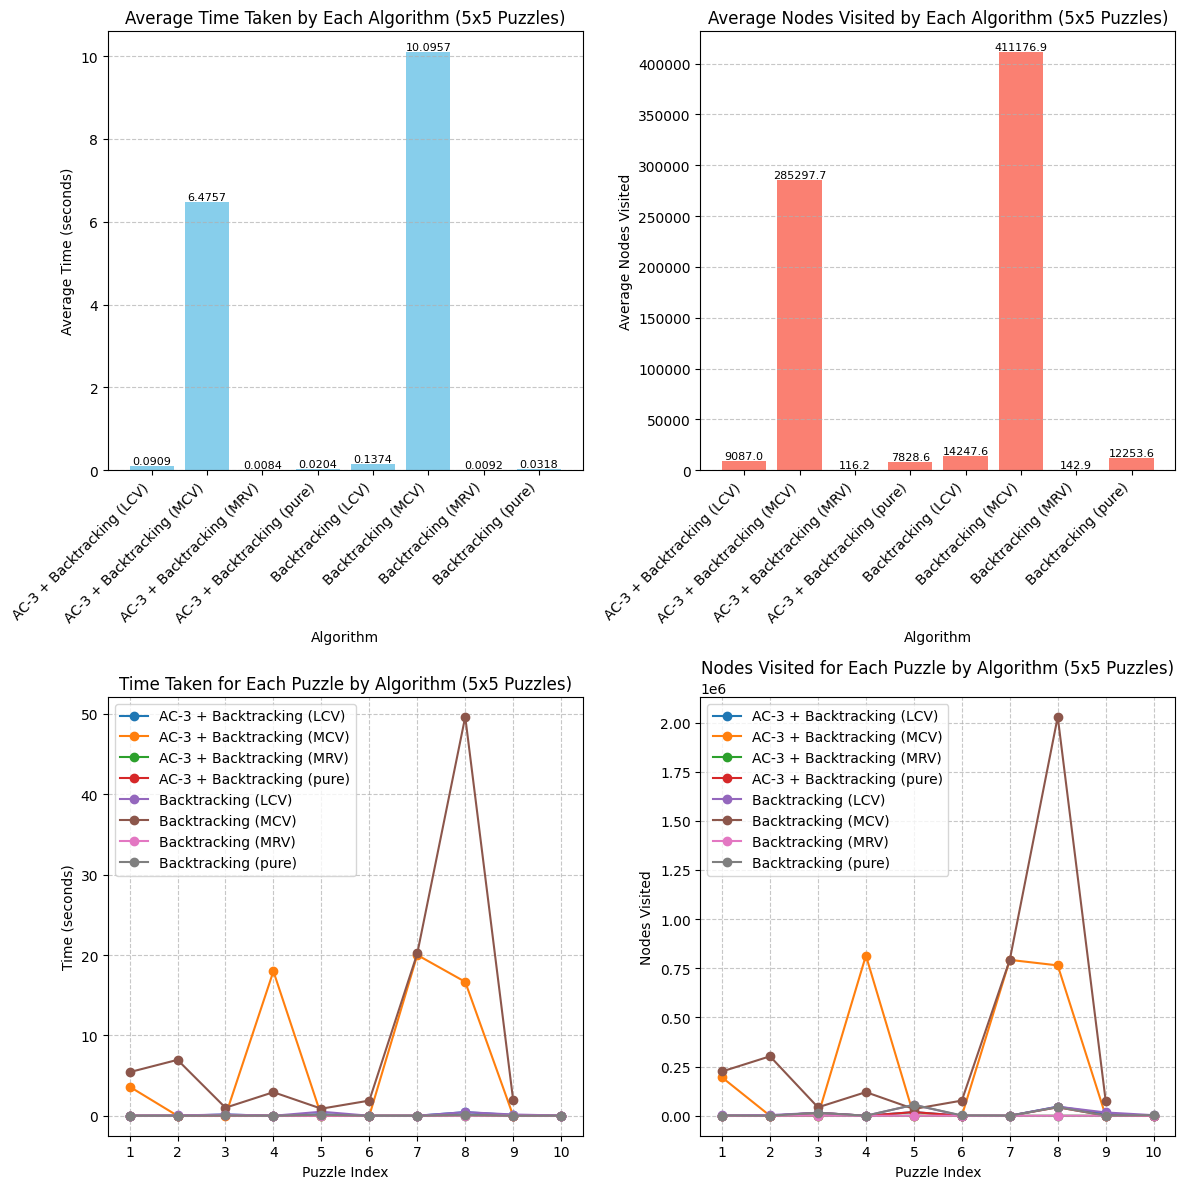

In [37]:
graph_metrics(metrics_7x7)

### 3. Algorithms performance comparison for 9x9 puzzles

In [ ]:
metrics_9x9 = read_metrics_csv('./puzzles_metrics/kakurasu_9x9_metrics.csv')
if not metrics_9x9:
    file_9x9 = 'batch_puzzles/kakurasu_9x9_puzzles.txt'
    puzzles_9x9 = read_batch_puzzles(file_9x9)
    metrics_9x9 = run_all_algorithms(puzzles_9x9)
    save_metrics_to_csv(metrics_9x9, './puzzles_metrics/kakurasu_9x9_metrics.csv')

In [ ]:
graph_metrics(metrics_9x9)

### 4. Algorithms performance comparison for 20x20 puzzles

In [ ]:
metrics_20x20 = read_metrics_csv('./puzzles_metrics/kakurasu_20x20_metrics.csv')
if not metrics_20x20:
    file_20x20 = 'batch_puzzles/kakurasu_20x20_puzzles.txt'
    puzzles_20x20 = read_batch_puzzles(file_20x20)
    metrics_20x20 = run_all_algorithms(puzzles_20x20)
    save_metrics_to_csv(metrics_20x20, './puzzles_metrics/kakurasu_20x20_metrics.csv')

In [ ]:
graph_metrics(metrics_20x20)

## Sources:

- Notebook code: https://github.com/walter-amador/csp_kakurasu_solver/blob/main/claude_opus_4_6.json
- Puzzles Generator: https://github.com/walter-amador/csp_kakurasu_solver/blob/main/generator_claude_sonnet_4_6.json
- Concept understanding: https://chatgpt.com/share/69a37abd-e354-8010-9eee-cb9a071228a5